In [2]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [3]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']


2450083.5


In [18]:
dates = []
distances = []
firstOrderFluxes = []
centralOrderFluxes = []

for i in range(1995,2025):
    try:
        datachunk = Table.read("./CELIAS-SEM/{0}_v4.day".format(str(i)[2:4]), format="ascii.no_header", guess=False, fast_reader=False, comment=";", data_start=0)
    except FileNotFoundError:
        continue
    datachunk.rename_column('col1', 'jd') 
    datachunk.rename_column('col13','distance')           # distance from Sun in km
    datachunk.rename_column('col15','firstOrderFlux')     # at distance given in column above. units photons cm^-2 s^-1
    datachunk.rename_column('col16','centralOrderFlux')   # at distance given in column above. units photons cm^-2 s^-1

    dates.extend(datachunk['jd'])
    distances.extend(datachunk['distance'])
    firstOrderFluxes.extend(datachunk['firstOrderFlux'])
    centralOrderFluxes.extend(datachunk['centralOrderFlux'])
    #print(datachunk['jd'][0])
    #print('')
    #print(datachunk['jd'][-1])

dates = np.array(dates)
distances = np.array(distances)
firstOrderFluxes = np.array(firstOrderFluxes)
centralOrderFluxes = np.array(centralOrderFluxes)

print(np.shape(dates))
print(np.shape(distances))
print(np.shape(firstOrderFluxes))
print(np.shape(centralOrderFluxes))

(10632,)
(10632,)
(10632,)
(10632,)


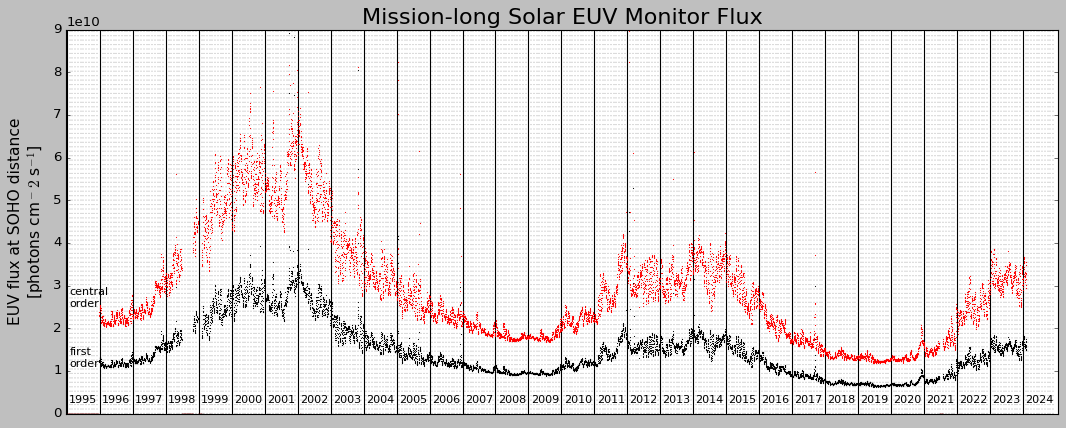

In [34]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(dates, firstOrderFluxes, 'k.',ms=1)
ax.plot(dates, centralOrderFluxes, 'r.',ms=1)

ax.set_xlim(dates[0] - 10, dates[-1] + 350)
ax.set_xticks([])
for y in range(1995, 2025):
    jan1 = str(y) + '-01-01T00:00:00.000Z'
    jan1 = astropy.time.Time(jan1).jd
    ax.axvline(jan1, color='k', ls='-', lw=1, zorder=1)
    
    ax.text(jan1+25, 0.025e11, str(y), zorder=4,fontsize=10)
        
    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)

ax.set_ylim(0.,0.9e11)
ax.text(dates[0]+25,1.1e10,'first'+'\n'+'order',fontsize=10)
ax.text(dates[0]+25,2.5e10,'central'+'\n'+'order',fontsize=10)

ax.set_ylabel(r'EUV flux at SOHO distance'+'\n'+'[photons cm${^-2}$ s$^{-1}$]',fontsize=14)
ax.set_title('Mission-long Solar EUV Monitor Flux',fontsize=20)

#plt.show()
plt.savefig("./SEM_missionlong_noDistCorrection.pdf",bbox_inches="tight")